In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
from datetime import datetime
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact, IntSlider
import ipywidgets as widgets
import arrow

#import dmyplant2
from dmyplant2 import (
    cred, MyPlant, Engine, 
    msgFSM, filterFSM, FSMPlot_Start, 
    bokeh_show, dbokeh_chart, add_dbokeh_vlines, get_cycle_data2, 
    disp_result, alarms_pareto, warnings_pareto, states_lines,
    detect_edge_right, detect_edge_left, plot_with_additional_results)
    
cred()
mp = MyPlant(3600)
Engine._list_cached_validations();

In [2]:
def sfun(x):
    return all([ ("BMW Landshut 4.10" in str(x['IB Site Name'])),  (x['OperationalCondition'] != 'Decommissioned') ])
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T;

In [3]:
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('BMW Landshut 4.10 M4', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [4]:
e=Engine.from_fleet(mp,motor)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to='2019-01-16', successtime=300)

In [5]:
#fsm = msgFSM(e, p_to='2022-02-01', successtime=600)
#fsm = msgFSM(e, p_from='2022-01-26', p_to='2022-02-01', successtime=600)
#fsm.store()

In [6]:
fsm.run1(enforce=False) # run Finite State Machine
#fsm.store()

fldstmp: 09.01.2019 00:59:44   |0001| 09.01 00:56:59 synchronize       | 09.01 00:57:25 loadramp          | on  | ???   | 600 09.01.2019 00:58:30 2858 Function power factor setpoint enabled
fldstmp: 10.01.2019 15:00:59   |0002| 10.01 14:58:27 synchronize       | 10.01 14:58:40 loadramp          | on  | AUTO  | 600 10.01.2019 14:59:44 2878 SCR Urea dosing activated
fldstmp: 10.01.2019 15:00:59   |0002| 10.01 14:58:27 synchronize       | 10.01 14:58:40 loadramp          | on  | AUTO  | 700 10.01.2019 15:00:35 2610 No connection to the sensor - NOx sensor engine out
fldstmp: 10.01.2019 15:00:59   |0002| 10.01 14:58:27 synchronize       | 10.01 14:58:40 loadramp          | on  | AUTO  | 600 10.01.2019 15:00:35 1240 Group alarm - warning
fldstmp: 10.01.2019 15:00:59   |0002| 10.01 14:58:27 synchronize       | 10.01 14:58:40 loadramp          | on  | AUTO  | 700 10.01.2019 15:00:35 9209 No connection to the sensor - NOx sensor CAT out
fldstmp: 10.01.2019 15:00:59   |0002| 10.01 14:58:27 sync

In [7]:
rdf = fsm.starts
rda = rdf[:].reset_index(drop='index')
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))].reset_index(drop='index')
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
#rda[filterFSM.run2filter_content].round(2)
print(f"Starts: {rdf.shape[0]}, Successful: {rdf[rdf['success'] == True].shape[0]}, Failed: {rdf[rdf['success'] == False].shape[0]} => {rdf[rdf['success'] == True].shape[0]/rdf.shape[0]*100.0:3.1f}%")

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

Starts: 69, Successful: 8, Failed: 61 => 11.6%


In [8]:
rda[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,265.13,4.41,14.31,7.97,25.82,138.89,456.527998,,,132813.68,127.53,0.0,49.41,0.0,4.0
1,1,False,AUTO,350.7,4.64,15.0,49.26,12.5,138.89,570.986998,,,50.8,,,,1.0,3.0
2,2,False,AUTO,325.17,4.03,15.22,7.46,11.98,45.38,409.234998,,,,,,,1.0,0.0
3,3,True,AUTO,265.01,4.74,13.91,7.67,19.33,-1607.83,-1297.189001,,,109764.89,96.69,0.0,49.47,0.0,7.0
4,4,False,AUTO,255.37,,,,,,255.372,,,,,,,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,64,True,MANUAL,302.27,4.44,14.11,7.36,20.47,138.89,487.533998,,,11931.2,103.01,0.0,49.61,0.0,4.0
65,65,True,AUTO,264.77,4.55,14.7,7.85,16.73,138.89,447.495998,,,995.74,104.96,0.0,49.48,0.0,5.0
66,66,True,AUTO,265.49,4.73,14.52,7.46,26.42,138.89,457.510998,,,9139.21,96.64,0.0,49.82,0.0,2.0
67,67,True,AUTO,265.01,4.14,15.09,7.76,28.02,138.89,458.907999,,,2435.78,96.68,0.0,49.8,0.0,0.0


In [9]:
rdd = rda[rda['loadramp'] < 0.0]
rdd[filterFSM.run2filter_content].round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
3,3,True,AUTO,265.01,4.74,13.91,7.67,19.33,-1607.83,-1297.189001,,,109764.89,96.69,0.0,49.47,0.0,7.0
11,11,False,AUTO,200.81,4.73,14.10,0.10,45.14,-295.72,-30.820002,,,0.00,,,,0.0,0.0
18,18,False,AUTO,195.12,4.73,14.23,0.10,44.43,-3128.72,-2870.114001,,,0.00,,,,0.0,0.0
23,23,False,AUTO,200.71,4.22,15.22,0.10,43.73,-2088.85,-1824.867001,,,0.00,,,,0.0,0.0
27,27,False,AUTO,265.48,4.14,15.72,0.10,42.68,-3453.70,-3125.573002,,,0.00,,,,0.0,0.0
31,31,False,AUTO,200.69,8.56,12.09,0.10,43.76,-299.36,-34.161002,,,0.00,,,,0.0,0.0
33,33,False,AUTO,266.09,4.84,15.82,43.33,26.49,-1687.91,-1331.352001,,,0.00,,,,0.0,0.0
36,36,False,AUTO,200.64,5.14,16.85,0.10,42.74,-285.22,-19.749001,,,0.00,,,,0.0,0.0
40,40,False,AUTO,266.26,5.13,16.63,8.15,6.95,-2131.90,-1828.769002,,,0.10,41.5,,,0.0,0.0
43,43,False,AUTO,200.66,6.33,23.37,0.10,42.55,-299.49,-26.478003,,,0.00,,,,0.0,0.0


In [10]:
fsm.results['starts'][0];

In [ ]:
#Execute FSM Run 2
#fsm.restore()
#rda = fsm.run2(rda, silent=False)
#fsm.store()

In [11]:
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb = rda
#rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2)

,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,targetoperation,rampdown,coolrun,runout
count,68.00,63.00,61.00,61.00,36.00,0.0,0.0,22.00,9.00,8.00,7.00
mean,249.29,15.06,7.68,39.13,-493.58,NaN,NaN,13280.16,84.83,6.62,49.63
std,50.05,3.33,7.80,21.36,1000.26,NaN,NaN,35587.94,38.94,18.73,0.18
min,85.32,5.13,0.10,4.26,-3453.70,NaN,NaN,0.00,0.30,0.00,49.41
25%,200.73,14.10,7.14,20.47,-307.29,NaN,NaN,0.00,96.12,0.00,49.48
50%,265.01,14.70,7.66,42.68,42.11,NaN,NaN,0.10,96.68,0.00,49.61
75%,266.38,15.67,8.15,58.32,44.73,NaN,NaN,2202.42,103.01,0.00,49.80
max,366.42,30.16,49.26,81.96,138.89,NaN,NaN,132813.68,127.53,52.97,49.82


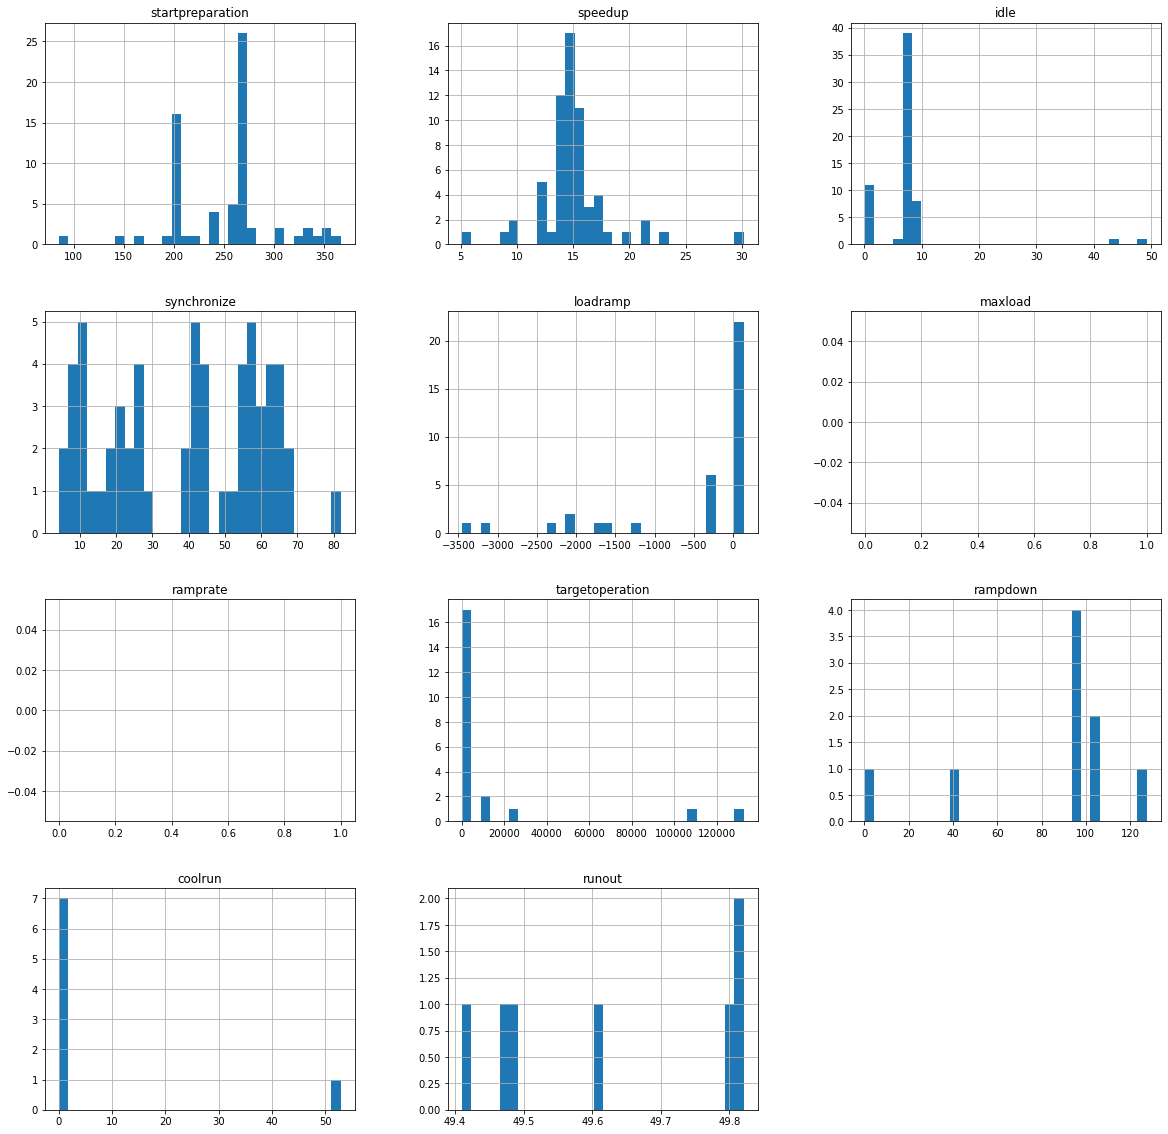

In [12]:
vec = ['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','rampdown','coolrun','runout']
display(_=rdb[vec].hist(bins=30,figsize=(20,20)))
#ax_list[0][2].set_xlim((0,10))
#display(rdb[vec].hist(bins=30,figsize=(20,20)))
display(rdb[vec].describe().round(2))

In [13]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success'])].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dfigsize = (18,12)
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-20,300)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['no'],'ylim':(-100,10000),'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='both', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
del(fig)

In [14]:
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]

In [15]:
rdb[filterFSM.run2filter_content].sort_values(by=["synchronize","loadramp"], ascending=[True,True]).round(2).fillna('')

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
53,53,False,MANUAL,366.42,6.47,5.13,9.63,4.26,36.99,428.895998,,,,,,,0.0,0.0
62,62,True,MANUAL,275.36,4.83,14.22,8.56,6.24,138.89,448.095999,,,1502.36,0.3,52.97,,1.0,7.0
59,59,False,MANUAL,352.6,6.96,12.28,8.48,6.95,37.3,424.569998,,,,,,,0.0,0.0
40,40,False,AUTO,266.26,5.13,16.63,8.15,6.95,-2131.9,-1828.769002,,,0.1,41.5,,,0.0,0.0
32,32,False,AUTO,237.85,5.25,16.0,6.94,7.86,43.14,317.029998,,,,,,,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,7,False,AUTO,255.48,,,,,,255.476,,,,,,,1.0,0.0
45,45,False,AUTO,267.51,7.36,9.66,,,,284.528999,,,,,,,0.0,0.0
52,52,False,AUTO,267.18,6.35,10.08,,,,283.615998,,,,,,,0.0,0.0
63,63,False,MANUAL,85.32,,,,,,85.319,,,,,,,1.0,0.0


In [16]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    disp_result(startversuch)
interact(f, x = IntSlider(0, 0, rdb.shape[0]-1 , 1, layout=widgets.Layout(width='90%')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='90%'), max=68), Output()), _dom…

In [21]:
%reload_ext autoreload
%aimport -pandas, -numpy
%autoreload 2
startversuch = rdb.iloc[v]; 
fig = plot_with_additional_results(fsm,startversuch, vset, dset, dfigsize=(16,8))

von: 10.01.2019 15:52:04 bis: 11.01.2019 22:30:09


state,severity,Number,date,message
targetoperation,700,2610,10.01.2019 15:59:04,No connection to the sensor - NOx sensor engine out
targetoperation,700,9209,10.01.2019 15:59:04,No connection to the sensor - NOx sensor CAT out
targetoperation,700,3509,10.01.2019 15:59:42,Heating water return temperature after cooler high
targetoperation,700,3527,10.01.2019 15:59:47,Heating water return temperature before engine high
targetoperation,700,3160,10.01.2019 16:00:00,Gas volume measuring signal failure
targetoperation,700,3482,10.01.2019 16:07:04,SCR Check NOx emissions
targetoperation,700,3160,10.01.2019 16:07:22,Gas volume measuring signal failure


In [22]:
sv = startversuch.to_dict()
x0 = sv['timing']['loadramp'][-1]['start']
y0 = 0.0
default_ramp_duration = 100.0 / fsm._e['rP_Ramp_Set']
x1 = x0 + pd.Timedelta(default_ramp_duration, unit='sec')
y1 = fsm._e['Power_PowerNominal']
x0,x1,y0,y1, default_ramp_duration

(Timestamp('2019-01-10 15:57:15.384000'),
 Timestamp('2019-01-10 15:59:34.272888889'),
 0.0,
 4500.0,
 138.88888888888889)

In [23]:
from bokeh.models import Span
ramp = fig.line(x=[x0,x1],y=[y0,y1], y_range_name='0', line_color='green', line_dash='dotted', line_alpha=0.4, line_width=4)
fig.add_layout(ramp)

c = fig.circle(x0,y0)
fig.add_layout(c)

this = Span(location=x0,dimension='height', y_range_name='0',line_color='blue', line_dash='solid', line_alpha=0.4, line_width=4)
fig.add_layout(this) 


In [24]:
bokeh_show(fig)

In [25]:
fsm.starts.iloc[v].to_dict()

{'run2': False,
 'no': 3,
 'success': True,
 'mode': 'AUTO',
 'starttime': Timestamp('2019-01-10 15:52:04.740000'),
 'endtime': Timestamp('2019-01-11 22:30:09.119000064'),
 'cumstarttime': -1297.1890010000002,
 'startpreparation': 265.005999,
 'starter': 4.735,
 'speedup': 13.908,
 'idle': 7.667,
 'synchronize': 19.328,
 'loadramp': -1607.833,
 'targetoperation': 109764.888,
 'rampdown': 96.686999,
 'coolrun': 0.0,
 'runout': 49.474,
 'timing': {'startpreparation': [{'start': Timestamp('2019-01-10 15:52:04.740000'),
    'end': Timestamp('2019-01-10 15:56:29.745999872')}],
  'starter': [{'start': Timestamp('2019-01-10 15:56:29.745999872'),
    'end': Timestamp('2019-01-10 15:56:34.480999936')}],
  'speedup': [{'start': Timestamp('2019-01-10 15:56:34.480999936'),
    'end': Timestamp('2019-01-10 15:56:48.388999936')}],
  'idle': [{'start': Timestamp('2019-01-10 15:56:48.388999936'),
    'end': Timestamp('2019-01-10 15:56:56.056000')}],
  'synchronize': [{'start': Timestamp('2019-01-10 15

In [26]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=False)):
    print(f"{i:3} {v}")

  0 * |0003| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | off | AUTO  | 600 10.01.2019 15:52:04 1231 Request module on
  1   |0004| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | on  | AUTO  | 600 10.01.2019 15:52:04 1277 Demand exhaust gas scavenging fan on
  2   |0004| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | on  | AUTO  | 600 10.01.2019 15:52:04 1261 Demand oil pump (DC) on
  3   |0004| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | on  | AUTO  | 600 10.01.2019 15:52:04 1259 Demand oil pump on
  4   |0004| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | on  | AUTO  | 600 10.01.2019 15:52:04 1257 Demand engine cooling water pump on
  5   |0004| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | on  | AUTO  | 600 10.01.2019 15:52:04 1262 Demand oil pump (DC) off
  6   |0004| 10.01 15:28:54 standstill        | 10.01 15:52:04 startpreparation  | on

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)